# Counterfactual GAN for macroeconomic policy simulations

The core idea is to use **counterfactual shifts** to simulate macroeconomic indicator variable timeseries based on changes in one key indicator variable $i$ - the conditioning variable $c$. For example, to determine the effectiveness of a certain central bank policy measured by $\textbf{x} = {x_1, x_2, ..., x_m}, \textbf{x} \subset X \land i \in X$ with $\textbf{x} = X \setminus y$ when the exchange rate for a certain currency would $i$ would have been different from that found in the real data (counterfactually shifting $i$ to $c$ under macroeconomic scenario $s$), one needs to be able to model the effect of changes in variable $i$ on all other variables $\textbf{x}$ in the dataset $X$.

##### The Bayesian model

To formalize, we need to model both the joint probability

$$ P(i_t,\textbf{x}_t) = P(X_{t-n:t-1}|i_{t-n:t-1},\textbf{x}_{t-n:t-1}), i \in X, \textbf{x} \subset X, i \notin \textbf{x}$$

of the conditioning variable $i$ and the conditioned variables $\textbf{x} \subseteq X$ at time $t$ conditional on previous timesteps ${t-n, ..., t-1}$, **and** the conditional probability of $\textbf{x}$ given $i$ at time $t$,

$$P(\textbf{x}_t|y_t)$$

From a Bayesian point of view, it makes sense to take the distribution in the real data as the prior. This means that the CGAN needs to
1. Approximate the $n$ historical autoregressive priors for all variables $p(X_t|X_{t-n:t-1})$ at $X_t$ given $X_{t-n}, ..., X_{t-1}$.
2. Infer the posterior distribution $p(X_{t-n:t-1},\beta,\gamma|X_t) \propto p(X_t|X_{t-n:t-1},\beta,\gamma)p(X_t|X_{t-n:t-1})$, where $\gamma$ maps contemporary relationships between variables at time $t$ and $\beta$ models the autoregressive relationship over time for all variables, mapping $X_{t-n:t-1}$ on to $X_t$.
3. Use the inferred posterior of the variables $\textbf{x}$ to generate $Y = c,P(\textbf{x}|c,s,\beta,\gamma)$, where $c$ is the conditioned form of $i$ shifted to simulate some explicitly programmed counterfactual scenario $s$, and $P(\textbf{x}|c,s)$ are the values of $\textbf{x}$ mapped onto this counterfactual scenario $s$. 

Given that a scenario $s$ can also be modeled as a regime, it might be good to look into RL research on the topic of policy switches in model-based RL.

##### Counterfactuals

From a causal inference standpoint, policy simulations should result in an estimate of either individual treatment effects ($ITE_i = Y_1^{(i)} - Y_0^{(i)}$ for treatment (1) and non-treatment (0) conditions on unit $i$), or average treatment effects ($ATE = 1/N \sum\limits_i y_1(i) - y_0(i)$) of the policy intervention $c$ on the other variables $\textbf{x}$.

In the language of causal analysis, the factual variable $i$ and counterfactual variable $c$ under scenario $s$ are investigated. Therefore the generator should learn to model not only the generated variables but also underlying confounders, which are hypothesized to aide in generating more realistic simulations.

##### Training and inference

Translating the Bayesian model to a GAN framework,
* The generator generates datapoints conditional both on $\textbf{A}$) autoregressive previous timesteps ${t-n, ..., t-1}$ and $\textbf{B}$) lateral relationships between variables (longitudinal and contemporary effects), ignoring $\textbf{C}$) the conditional variable $c$ during training.
* The discriminator is used to train the generator to model $\textbf{A}$) and $\textbf{B}$) as realistically as possible.
* During inference $c$ is shifted to simulate the counterfactual condition $\textbf{C}$), letting the generator model the effect of $c$ on the $x \subset X$ variables of interest.

The training data will come from a training pool consisting of datapoints for some 100 or so countries, shuffled for training purposes but with country encodings to allow the model to learn different distributions. The validation data consists of a separate pool of 15 heterogeneous countries.

The model learns to predict variables $\textbf{i}_t = \textbf{x}_t$ at time $t$ given $\textbf{x}_{t-1}$ within the context of $\textbf{x}_{t-n:t-1}$. For practical purposes the data feed consists of multivariate sequences of length $n-1$, and multivariate labels with length $1$. During inference, the model needs to have access to predictions at it made at previous timesteps in order to set the generated context $\hat{\textbf{x}}_{t-n:t-1}$.

##### Loss functions

The correctness of the generator can be measured by proxy by looking at **reconstruction losses** from historical data. I.e., provide it with a prompt of $m$ sequences on unseen historical country data, and determine how close it matched the real data for the remaining $n-m$ observations. Given the natural differences in country data, it might be good to take a pool of representative countries as the validation dataset. This will also help mitigate covariate shift issues (c.f. [Johansson et al. 2018](https://arxiv.org/abs/1605.03661)).

Since we are dealing with counterfactuals, the loss metric cannot be measured directly from labeled data. However, a proxy of **counterfactual loss** could be to measure the proportional, variable-bound divergence of the simulated data from the real distribution, for example through Kullback-Leibler divergence, Fisher information, or optimal transport. The assumption underlying such an approach would be that of *real-world constraints* on macroeconomic data, i.e. the overall quantities of the indicator variable won't change as a result of counterfactual evidence, but their underlying distribution might.

##### Counterfactual GAN

The generator models $\beta$ and $\gamma$ through the same parameter set, as is current best practice in sequence modeling. One obvious candidate architecture that springs to mind are transformer networks, for example the [universal transformer](https://arxiv.org/abs/1807.03819) architecture. 

A correct measurement of the loss will need to incorporate covariate shifts across country datasets into the function. One widely-used metric to include a measure thereof in the loss function is maximum-mean discrepancy (MMD, c.f. [Gretton et al., 2012](http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf), [Sutherland et al., 2107](https://arxiv.org/abs/1611.04488)), which can be estimated empirically over the means of the real and simulated data distributions. 

*// TODO: investigate loss functions for time series generation and simulation models.*

##### Simulation

*// TODO: implement inference layer that allows for the combination of manually conditioned timeseries data $c$ and generated data $x$.*


###### Generalization

*// TODO: develop tests and visualisations to check the generalization capabilities of the model.*

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [4]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [5]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

#### Load and prepare the data

In [ ]:
# validation_countres = ['France']

In [ ]:
country = 'France'

In [7]:
features_df = pd.read_csv('features/m_one/%s_features.csv' % country, sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [8]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [9]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


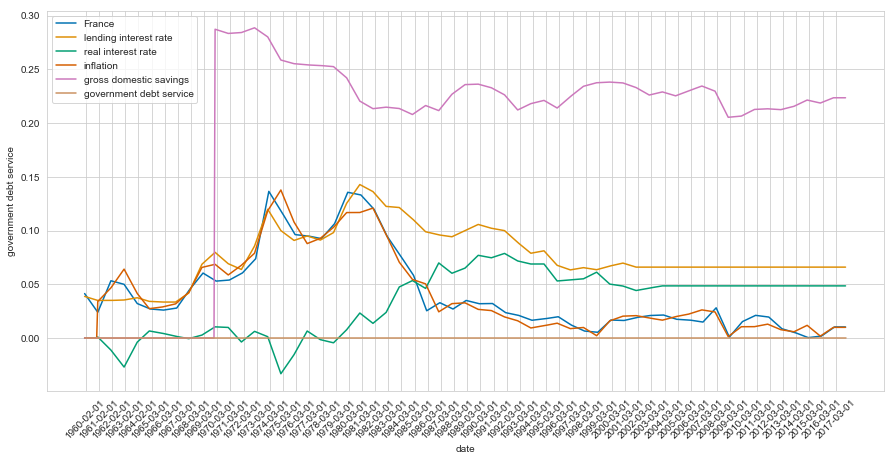

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [11]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'urban population', 'Brazil', 'China', 'Colombia', 'France', 'Ghana',
       'India', 'Indonesia', 'Japan', 'Netherlands', 'Seneg

In [12]:
base_feature_df = combined_df[['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'urban population', country]]

In [13]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date');

In [14]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

In [15]:
gan_df = base_df[['label']]
gan_df.shape

(696, 1)

In [16]:
gan_cols = gan_df.shape[1]

## Conditional generative adverserial network

* The generator consists of a transformer architecture adapted for continous time series simulations.
* The discriminator optimises for similarities in distributions across real and simulated data and corectness of the learnt distribution w.r.t. validation data.
* Conditional time series can be fed to the architecture to investigate counterfactual scenarios through simulation studies.

In [43]:
from keras.models import Sequential, Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [44]:
gan_params = {
   'num_epochs': 2000,
   'save_interval': 100,
   'sequence_length': 3,
   'num_variables': gan_cols,
   'batch_size': 32,
   'lr': 0.1 
}

In [46]:
generator_params = {
   'num_layers': 4,
   'd_model': 128,
   'dff': 512,
   'num_heads': 8,
   'num_timesteps': gan_params['sequence_length'],
   'dropout_rate': 0.1
}

In [20]:
discriminator_params = {
   'bi_lstm_units': 64,
   'dropout_rate': 0.3,
   'lr': 0.01
}

In [21]:
gan_features = []
gan_labels = []

for i in range(int(num_obs / gan_params['sequence_length'])):
    gan_labels_df = gan_df['label']
    gan_labels.append(gan_labels_df[i:(i+gan_params['sequence_length'])].values[-1:])
    gan_features.append(gan_df[i:(i+gan_params['sequence_length'])].values)

In [22]:
real = np.asarray(gan_features)
real = real.reshape((real.shape[0], gan_params['sequence_length'], gan_cols))

In [23]:
real.shape

(232, 3, 1)

### Generator

The generator consists of a time series [universal transformer](https://arxiv.org/abs/1807.03819) with relative positional embeddings. Since the autoregression of interest is learnt from the context (previous timesteps) rather than from the position of the variable in $\textbf{x}$ (where ordering is random), some modifications had to be made to ensure the model learnt correct dependencies between variables in the multivariate set $\textbf{x}$. Furthermore, rather than tokens, the generator needs to learn continous variables. The approach here is inspired by an application of the transformer architecture to music generation by [the Google Magenta team](https://magenta.tensorflow.org/music-transformer).

The Transformer implementation in TensorFlow Keras is adapted for timeseries from [the TensorFlow transformer tutorial](https://www.tensorflow.org/beta/tutorials/text/transformer) for neural machine translation.

In [24]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [25]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [26]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [28]:
from keras.layers import Dense

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)
          
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
      
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
      
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
      
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    
        output = self.dense(concat_attention)
        return output, attention_weights

In [29]:
from keras.layers import Dense

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([Dense(dff, activation='relu'), Dense(d_model)])

In [36]:
from keras.layers import Dropout

class TimeseriesEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_timesteps, rate=0.1):
        super(TimeseriesEncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
      
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [37]:
from keras.layers import Dropout

class TimeseriesDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_timesteps, rate=0.1):
        super(TimeseriesDecoderLayer, self).__init__()
    
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
    
        self.ffn = point_wise_feed_forward_network(d_model, dff)
     
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)
      
      
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [38]:
from keras.layers import Embedding, Dropout

class TimeseriesEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_timesteps, rate=0.1):
        super(TimeseriesEncoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        
        self.pos_encoding = positional_encoding(num_timesteps, self.d_model)        
        self.enc_layers = [TimeseriesEncoderLayer(d_model, num_heads, dff, num_timesteps, rate) 
                           for _ in range(num_layers)]
      
        self.dropout = Dropout(rate)
            
    def call(self, x, training, mask):
        x = tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_timesteps, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [39]:
from keras.layers import Embedding, Dropout

class TimeseriesDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_timesteps, rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.pos_encoding = positional_encoding(num_timesteps, self.d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, num_timesteps, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)
      
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attention_weights = {}
        
        x = tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_timesteps, :]
        
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

In [40]:
class UniversalTimeseriesTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, num_timesteps, rate=0.1):
        super(UniversalTimeseriesTransformer, self).__init__()

        self.encoder = TimeseriesEncoder(num_layers, d_model, num_heads, dff, num_timesteps, rate)
        self.decoder = TimeseriesDecoder(num_layers, d_model, num_heads, dff, num_timesteps, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

In [41]:
from keras.layers import TimeDistributed, GaussianNoise, Dense, Reshape

def build_generator(params):
    gshape = params['sequence_length'], params['num_variables']
    inputs = Input(shape=(gshape))
    
    g = Sequential(name='generator')
    g.add(UniversalTimeseriesTransformer(inputs, g(inputs)))
    g.add(TimeDistributed(GaussianNoise(params['dropout'])))
    g.add(TimeDistributed(Dense(params['num_variables'])))
    g.add(Reshape(target_shape=(gshape)))
    g.summary()
    
    return Model(inputs, g(inputs))

In [47]:
generator = build_generator({**gan_params, **generator_params})

TypeError: __init__() missing 4 required positional arguments: 'num_heads', 'dff', 'input_vocab_size', and 'target_vocab_size'

### Discriminator

In [34]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense, concatenate, Flatten

def build_discriminator(params):
    dshape = params['sequence_length'], params['num_variables']
    batch_shape = params['batch_size'], params['sequence_length'], params['num_variables']
    
    real = Input(shape=(dshape))
    generated = Input(shape=(dshape))
    inputs = concatenate([generated, real], axis=1)
    
    d = Sequential(name='discriminator')
    d.add(Bidirectional(LSTM(params['bi_lstm_units']), batch_input_shape=(batch_shape)))
    d.add(Dropout(params['dropout_rate']))
    d.add(Dense(1, activation='sigmoid'))
    d.summary()
    return Model([generated, real], d(inputs))

In [35]:
discriminator = build_discriminator({**gan_params, **discriminator_params})
discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (32, 128)                 33792     
_________________________________________________________________
dropout_1 (Dropout)          (32, 128)                 0         
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


### CGAN

In [36]:
def build_cgan(generator, discriminator, params):
    ganshape = params['sequence_length'], params['num_variables']
    discriminator.trainable = False
    
    noise = Input(shape=(ganshape))
    generated = generator(noise)
    data = Input(shape=(ganshape))
    prediction = discriminator([data, generated])
    
    cgan = Model([noise, data], prediction, name='cgan')
    cgan.summary()
    return cgan

In [37]:
cgan = build_cgan(generator, discriminator, gan_params)
cgan.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3, 1)         264449      input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            33921       input_7[0][0]                    
                                                                 model_1[1][0]                    
Total para

In [38]:
def train_cgan(real, batch_size, params):
    g_metrics = []
    d_metrics = []
    
    reals = np.ones(batch_size)
    synths = np.zeros(batch_size)
    
    for i in range(params['num_epochs']):
        # create input of real and synthetic data
        random_index = np.random.randint(0, len(real) - batch_size)
        half_real = real[random_index:int(random_index + batch_size)]
        half_synth = np.random.normal(-1.0, 1.0, size=[batch_size, params['sequence_length'], real.shape[2]])
        
        # apply generator
        generated = generator.predict(half_synth)
        
        # train discriminator
        disc = discriminator.train_on_batch([generated, half_real], reals)
                                                            
        # train gan
        gen_ = cgan.train_on_batch([half_synth, generated], [reals])
        if i % 100 == 0:
            print('Epoch %s losses: discriminator %s, generator: %s' % (i, str(disc[0]), str(gen_[0])))
        
        d_metrics.append(disc)
        g_metrics.append(gen_)
    return d_metrics, g_metrics

In [39]:
d_metrics, g_metrics = train_cgan(real, gan_params['batch_size'], gan_params)

Instructions for updating:
Use tf.cast instead.
Epoch 0 losses: discriminator 0.24995089, generator: 0.24700996
Epoch 100 losses: discriminator 6.8040305e-07, generator: 2.9198221e-05
Epoch 200 losses: discriminator 9.275328e-07, generator: 0.00011040808
Epoch 300 losses: discriminator 9.043461e-07, generator: 1.044011e-05
Epoch 400 losses: discriminator 5.7535186e-07, generator: 1.0638841e-05
Epoch 500 losses: discriminator 6.385929e-07, generator: 1.3963987e-05
Epoch 600 losses: discriminator 4.6983166e-07, generator: 1.3406103e-05
Epoch 700 losses: discriminator 6.366162e-07, generator: 4.278102e-06
Epoch 800 losses: discriminator 5.931344e-07, generator: 8.626929e-06
Epoch 900 losses: discriminator 3.625406e-07, generator: 4.7837093e-06
Epoch 1000 losses: discriminator 2.7623628e-07, generator: 4.2822608e-06
Epoch 1100 losses: discriminator 4.2129474e-07, generator: 8.186247e-06
Epoch 1200 losses: discriminator 3.0895427e-07, generator: 4.8671855e-06
Epoch 1300 losses: discriminato

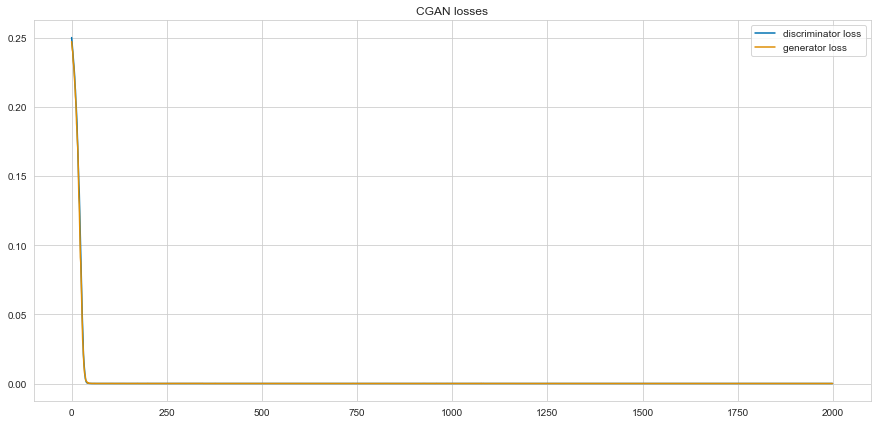

In [40]:
plt.figure(figsize=(15,7))
plt.plot([metrics[0] for metrics in d_metrics], label='discriminator loss')
plt.plot([metrics[0] for metrics in g_metrics], label='generator loss')
plt.legend()
plt.title('CGAN losses')
plt.show()

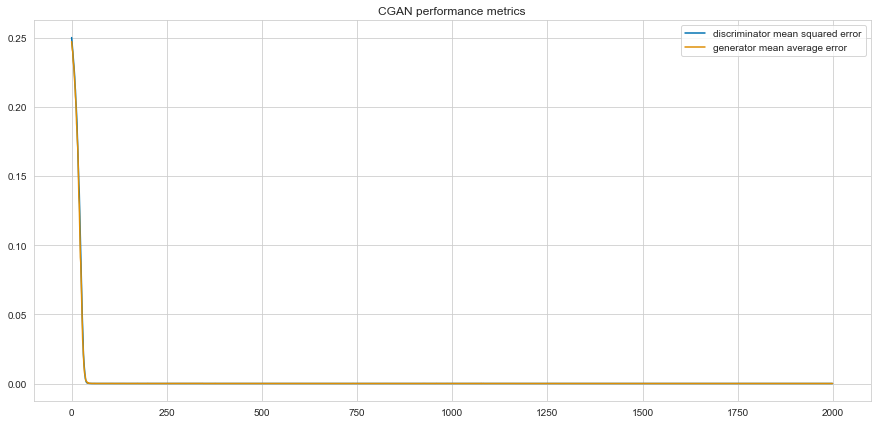

In [41]:
plt.figure(figsize=(15,7))
plt.plot([metrics[1] for metrics in d_metrics], label='discriminator mean squared error')
plt.plot([metrics[1] for metrics in g_metrics], label='generator mean average error')
plt.legend()
plt.title('CGAN performance metrics')
plt.show()

In [42]:
generated_y = generator.predict(np.random.rand(num_obs, gan_params['sequence_length'], gan_cols))[:,-1,-1]
gan_y = gan_df['label'].values

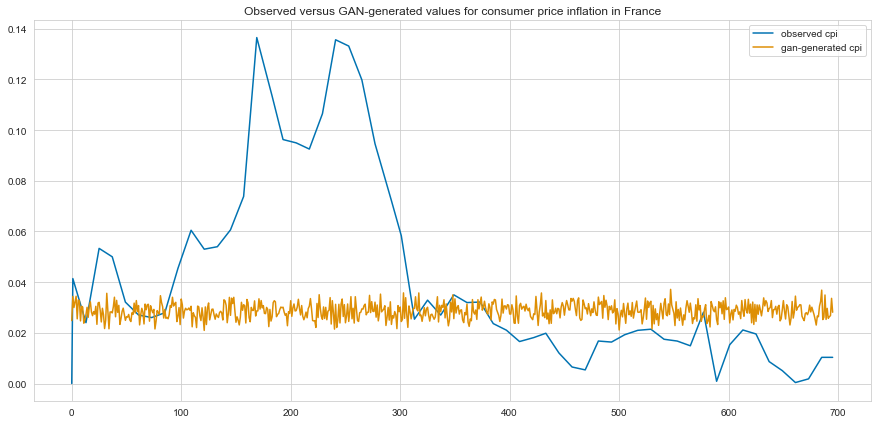

In [43]:
plt.figure(figsize=(15,7))
plt.plot(gan_y, label='observed cpi')
plt.plot(generated_y, label='gan-generated cpi')
plt.legend()
plt.title('Observed versus GAN-generated values for consumer price inflation in %s' % country)
plt.show()

In [44]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(gan_y, generated_y)),
                                                           np.mean(gan_y), np.mean(generated_y)))

rmse: 0.03926951250845506
mean observed: 0.04203555603346822
mean generated: 0.028582528
